#  Train CNN models for detecting particles

This notebook has two sections: 
1. The code to combine synthetic data and experimental data to train the model for the first time
2. The trained model is further tuned by training on tbe correctly annoted images after improving its mistakes.

The second section is very similar to the first one: only load the pretrained model and perform the same training operation 

In [1]:
# ................ import some modules ................
from pathlib import Path
import logging
import numpy as np
import glob
import torch
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split

# Build the package ... for future .... @ Samadarshi keeping developing on this lines .....
#!pip install -e ".."

In [2]:
# ........ import the user-defined modules ............
# imports the training data loading pipeline 
from data_funnel import ParticleDataset

# imports the CNN models
from models import UNetHeatmap

# imports the device check, training code and
from train_modules import train_model

# import general utility modules 
from utils.logger_utils import setup_logger
# for checking the graphic card ... optiional
from utils.GPU_check_utils import get_nvidia_info 
from utils.visualizations import visualize
from utils.config_utils import load_config

In [3]:
# Set the device for the training 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Train the model from scratch using synthetic and experimental data 

In [4]:
# ........... build the path architecture ........ 
cwd = Path().resolve() 
Parent = cwd.parent
# set file path architecture from the yaml file. 
path_data = load_config(str(cwd.parent / 'configs/config.yaml'))
# path to synthetic training data 
train_data_syn = cwd.parent /path_data['Images']['FirstTrain_syn']
# path to experimental training data 
train_data_exp = cwd.parent /path_data['Images']['FirstTrain_exp']
# path to the synthetic image heatmaps 
heatmap_data_syn = cwd.parent /path_data['Heatmaps']['FirstTrain_syn']
# path to the experimental image heatmaps 
heatmap_data_exp = cwd.parent /path_data['Heatmaps']['FirstTrain_exp']

# initiate the logging operations and correctly name the training operation 
setup_logger(str(cwd.parent /'logs'), exp_name="Trial", log_to_console=False)

'Trial_2025-06-17_23-04-57.log'

In [5]:
# check the GPU status and being detected correctly ... check the log file for this.
get_nvidia_info()

In [6]:
img_paths = sorted(glob.glob(str(train_data_syn) + '\*.png')) + sorted(glob.glob(str(train_data_exp) + '\*.png'))
   

In [7]:
if __name__ == "__main__":
 
    # declare some inital parameters.......
    RANDOM_state         = 42
    batch_size           = 8      # size of the batch of images  
    train_size           = 0.8    # ratio of data allocated for training 
    test_validate_split  = 0.5    # split the non-training data between test and validation
    
    # Model instatiation
    model = UNetHeatmap()      # Instatiate the model
    epochs = 1                # Epoch runs to train the model 
    lr = 1e-03                 # Set the learning rate.
    
    
    try : 
        
        logging.info('............ Started Training Setup ...............')
        
        # Sort to ensure matching order (assuming same file names)
        img_paths = sorted(glob.glob(str(train_data_syn) + '\*.png')) + sorted(glob.glob(str(train_data_exp) + '\*.png'))
        heatmap_paths = sorted(glob.glob(str(heatmap_data_syn) + '\*.npy')) + sorted(glob.glob(str(heatmap_data_exp) + '\*.npy'))

        # Pair them together
        pairs = list(zip(img_paths, heatmap_paths))

        # Train/val/test split
        train_pairs, temp_pairs = train_test_split(pairs, test_size=1-train_size, random_state=RANDOM_state)
        val_pairs, test_pairs = train_test_split(temp_pairs, test_size=test_validate_split, random_state=RANDOM_state)

        # Create datasets ... training, validation and test datasets .... 
        train_dataset = ParticleDataset(np.array(train_pairs).T[0], np.array(train_pairs).T[1])
        val_dataset = ParticleDataset(np.array(val_pairs).T[0], np.array(val_pairs).T[1])
        test_dataset = ParticleDataset(np.array(test_pairs).T[0], np.array(test_pairs).T[1])

        # Create the loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        # save info in the log
        logging.info(f"Training started for model: {model.__class__.__name__}")
        logging.info(f"Number of epochs: {epochs}")
        logging.info(f"Learning rate: {lr}")
        
        # start the training operations and log it as well.
        logging.info('..... Model loaded and starting the training .......')
        model = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr)
        logging.info('..... Finished training and validating the model  .......')
        # catch the error in case there is a training failure ..... @ Samadarshi added the log file thingy. 
    except Exception as e:
        logging.error(f".......The training failed || Error --->: {e}")     

Epoch 1/1: 100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


Epoch 1/1 || Train Loss: 0.0001 || Val Loss: 0.0000


### Visualise the model prediction

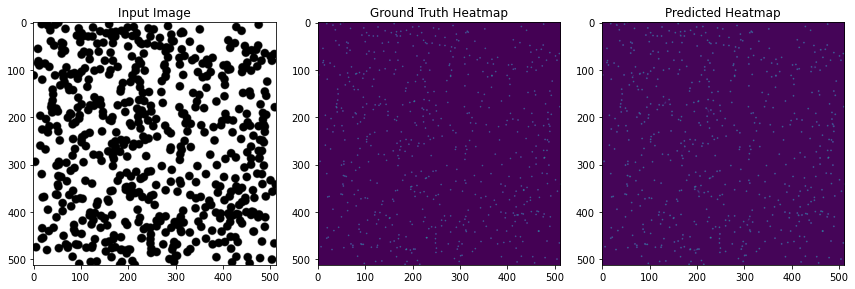

In [8]:
# Visualize
visualize(model, 'cpu',val_dataset, index=0)

### For checkpoints and save

In [ ]:
# for keeping the checkpoint ...make a class for this  ..... 
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'loss': loss,
}, "checkpoint.pth")

checkpoint = torch.load("checkpoint.pth", map_location=device)
model = MyModel(*args, **kwargs)
optimizer = torch.optim.Adam(model.parameters(), lr=new_lr)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint.get('epoch', 0)

In [9]:
# save the model and the state dict 
torch.save(model, str(cwd.parent/ 'model_weights'/ 'CNN_UNET_full_model_512.pth'))
torch.save(model.state_dict(),str(cwd.parent/ 'model_weights'/'CNN_UNET_full_model_state_dict_512.pth'))

## Now for the human-in-loop step after improving the labels via ImageJ

1. Check the mistakes made and then using ImageJ and Correct the mistaken coordinates
2. Train the data on the images and the corresp. heatmaps of corrected ground truth. 

In [31]:
# now load the model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cycle = UNetHeatmap().to(device)
state_dict = torch.load(str(root / 'CNN_UNET_full_model_state_dict.pth'), map_location=device)
model_cycle.load_state_dict(state_dict)

<All keys matched successfully>

Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.41it/s]


Epoch 1/1 || Train Loss: 0.0000 || Val Loss: 0.0000


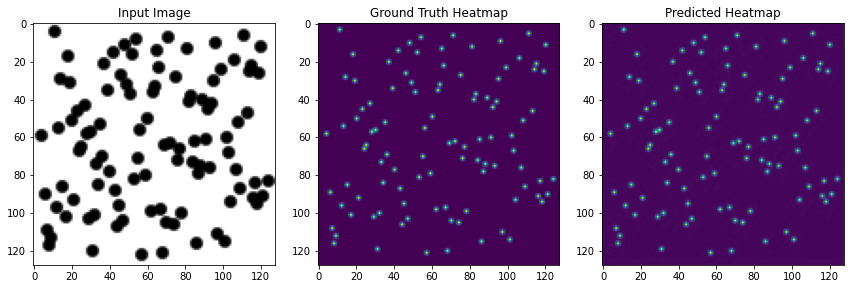

In [36]:
if __name__ == "__main__":
    
    # declare some inital parameters.......
    RANDOM_state         = 42
    batch_size           = 8      # size of the batch of images  
    train_size           = 0.8    # ratio of data allocated for training 
    test_validate_split  = 0.5    # split the non-training data between test and validation
    
    # Model instatiation
    model = UNetHeatmap()      # Instatiate the model
    epochs = 1                 # Epoch runs to train the model 
    lr = 1e-03                 # Set the learning rate.
    
    try : 
        logging.info('............ Started Training Setup ...............')
        
        # Sort to ensure matching order (assuming same file names)
        img_paths = sorted(glob.glob(str(cwd.parent / path_data['Images']['Correct_HumanOL']) + '\*.png')) 
        heatmap_paths = sorted(glob.glob(cwd.parent / path_data['Heatmaps']['Correct_HumanOL'] + '\*.npy')) 

        # Pair them together
        pairs = list(zip(img_paths, heatmap_paths))

        # Train/val/test split
        train_pairs, temp_pairs = train_test_split(pairs, test_size=1-train_size, random_state=RANDOM_state)
        val_pairs, test_pairs = train_test_split(temp_pairs, test_size=test_validate_split, random_state=RANDOM_state)

        # Create datasets ... training, validation and test datasets .... 
        train_dataset = ParticleDataset(np.array(train_pairs).T[0], np.array(train_pairs).T[1])
        val_dataset = ParticleDataset(np.array(val_pairs).T[0], np.array(val_pairs).T[1])
        test_dataset = ParticleDataset(np.array(test_pairs).T[0], np.array(test_pairs).T[1])

        # Create the loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
 
        # Model instatiation
        model = UNetHeatmap()
        epochs = 10
        lr = 1e-03
        
        # save info in the log
        logging.info(f"Training started for model: {model.__class__.__name__}")
        logging.info(f"Number of epochs: {epochs}")
        logging.info(f"Learning rate: {lr}")
        
        # start the training operations
        logging.info('..... Model loaded and starting the training .......')
        model = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr)
        
        # catch the error in case there is a training failure ..... @ Samadarshi added the log file thingy. 
    except Exception as e:
        logging.error(f".......The training failed || Error --->: {e}")     